In [96]:
import torch
import torch.nn.functional as F
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import munch
import yaml
import importlib

device = torch.device("cuda:0")


In [97]:
def get_ptcloud_img(ptcloud,roll,pitch):
    fig = plt.figure(figsize=(8, 8))

    x, z, y = ptcloud.transpose(1, 0)
    ax = fig.add_subplot(projection=Axes3D.name, adjustable='box')
    ax.axis('off')
    # ax.axis('scaled')
    ax.view_init(roll,pitch)
    max, min = np.max(ptcloud), np.min(ptcloud)
    ax.set_xbound(min, max)
    ax.set_ybound(min, max)
    ax.set_zbound(min, max)
    ax.scatter(x, y, z, zdir='z', c=y, cmap='jet')

    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3, ))
    return img

In [162]:
config_path = "/home/yuwu3/SpaceQA/Code/Preprocess/3DAttriFlow/cfgs/finetune.yaml"
ckpt_path = "/home/yuwu3/SpaceQA/Code/Preprocess/3DAttriFlow/finetune_output/SVR_3DAttriFlow-0426_1726/checkpoints/bestl1_network.pth"
args = munch.munchify(yaml.safe_load(open(config_path)))
model_module = importlib.import_module('.%s' % args.model_name, 'models')
net = model_module.Model(args).to(device)
if hasattr(model_module, 'weights_init'):
    net.module.apply(model_module.weights_init)
ckpt = torch.load(ckpt_path)
net.load_state_dict(ckpt['net_state_dict'])
net.eval()

Model(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [163]:
sys.path.append('/home/yuwu3/SpaceQA')
from Code.DataLoader.Space import SpaceDataset
from pathlib import Path
import pypose as pp

dataset = SpaceDataset(path=Path("/drive/yuwu3/CLEVRER_pre/Valid/video_10000-11000"))

torch.Size([3, 63, 64])
torch.Size([3, 224, 224])


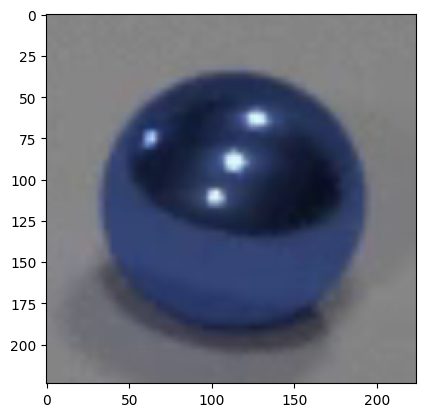

In [167]:
# for frames in dataset:
frames = dataset.__getitem__(3)
frame = frames[0]
frame_img = frame.image
obj_mask = frame.obj_mask.expand(3, 320, 480)
obj = frame.objects[0]
margin = 10
obj_image = frame_img[:, obj.min_v-margin:obj.max_v+margin, obj.min_u-margin:obj.max_u+margin,]
print(obj_image.shape)
plt.imshow(obj_image.permute(1,2,0))
obj_image = F.interpolate(obj_image.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)[0]
obj_image = obj_image.type(torch.float32) / 256
print(obj_image.shape)
plt.imshow(obj_image.permute(1,2,0))


[18:07:58] WARNING  /tmp/ipykernel_1791440/3112484987.py:16: MatplotlibDeprecationWarning: The      ]8;id=847922;file:///home/yuwu3/miniconda3/envs/11777/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=962064;file:///home/yuwu3/miniconda3/envs/11777/lib/python3.10/warnings.py#109\109]8;;\
                    tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two                 
                    minor releases later. Use buffer_rgba instead.                                                 
                      img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')                       
                                                                                                                   

           WARNING  /tmp/ipykernel_1791440/3112484987.py:16: DeprecationWarning: The binary mode of ]8;id=911982;file:///home/yuwu3/miniconda3/envs/11777/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=847555;file:///home/yuwu3/miniconda3/envs/11777/lib/python3.10/warnings.py#109\109]8;;\
                    fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use                    
                    frombuffer instead                                                                             
                      img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')                       
                                                                                                                   

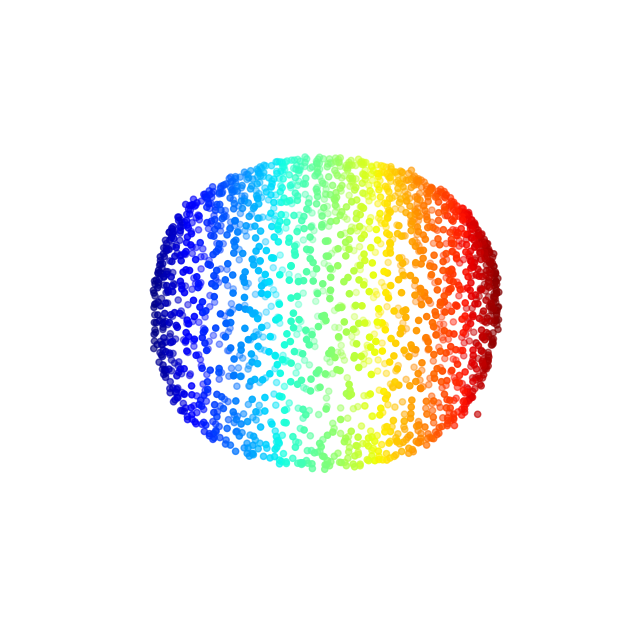

In [170]:
with torch.no_grad():
    pred_points = net(obj_image.unsqueeze(0).to(device))
pred_points = pred_points.cpu().numpy()[0]
img = get_ptcloud_img(pred_points, 30, 0)
